<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Machine Learning Using Python (MEAFA Workshop)</h1>
<h2 align="center" style="margin-top:10px">Lesson 2: Regularised Linear Models</h2>
<br>

<a href="House-Pricing Data">House Pricing Data</a> <br>
<a href="#Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#Response-Transformation">Response Transformation</a> <br>
<a href="#Scaling-the-Predictors">Scaling the Predictors</a> <br>
<a href="#Regularised-Linear-Models">Regularised Linear Models</a> <br>
<a href="#Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

# Methods
from sklearn.linear_model import LinearRegression

##House Pricing Data 

We use data from [De Cock (2011)](http://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627), who compiled a detailed dataset of residential property sales in a North American city. It is used in one of the most popular practice [Kaggle]()This dataset is characterised by a large number of predictor variables (81, including categorical, ordinal, discrete, and continuous variables). See the [documentation](https://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt) for a description of the original variables. 

I cleaned and processed the original dataset into a version that is ready analysis. The dataset has 196 variables after coding the categorical predictors using dummy variables and the creation of other relevant variables. 

In [4]:
data=pd.read_csv('Datasets/AmesHousing-Processed.csv')
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Age,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,GarageArea,LotArea,...,RoofMatl_Other,RoofStyle_Hip,RoofStyle_Other,ScreenPorchZero,WoodDeckSFZero,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SalePrice
0,1656,0,0,50,639.0,0.0,441.0,0,528.0,31770,...,0,1,0,1,0,0,0,0,1,215000
1,896,0,0,49,468.0,144.0,270.0,0,730.0,11622,...,0,0,0,0,0,0,0,0,1,105000
2,1329,0,0,52,923.0,0.0,406.0,0,312.0,14267,...,0,1,0,1,0,0,0,0,1,172000
3,2110,0,0,42,1065.0,0.0,1045.0,0,522.0,11160,...,0,1,0,1,1,0,0,0,1,244000
4,928,701,0,13,791.0,0.0,137.0,0,482.0,13830,...,0,0,0,1,0,0,0,0,1,189900


We the split the data into training and test sets. We use a small training dataset to better illustrate the advantages of regularisation. 

In [5]:
response='SalePrice'
predictors=list(data.columns.values[:-1])

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.2, random_state=5)

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

y_train = train[response]
y_test = test[response]

X_train = train[predictors].copy()
X_test = test[predictors].copy()

## Exploratory data analysis

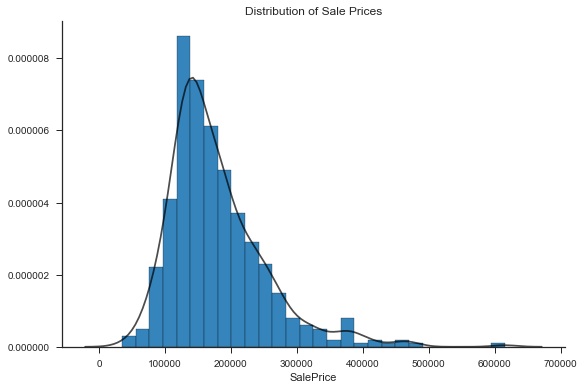

In [6]:
from statlearning import plot_histogram

plot_histogram(y_train)
plt.title('Distribution of Sale Prices')
plt.show()

Many of the numerical variables have a substantial number of zeros, since they refer to variables that do not apply to all houses (such as the second floor area). The dataset includes additional constructed features to account for this feature of the data.

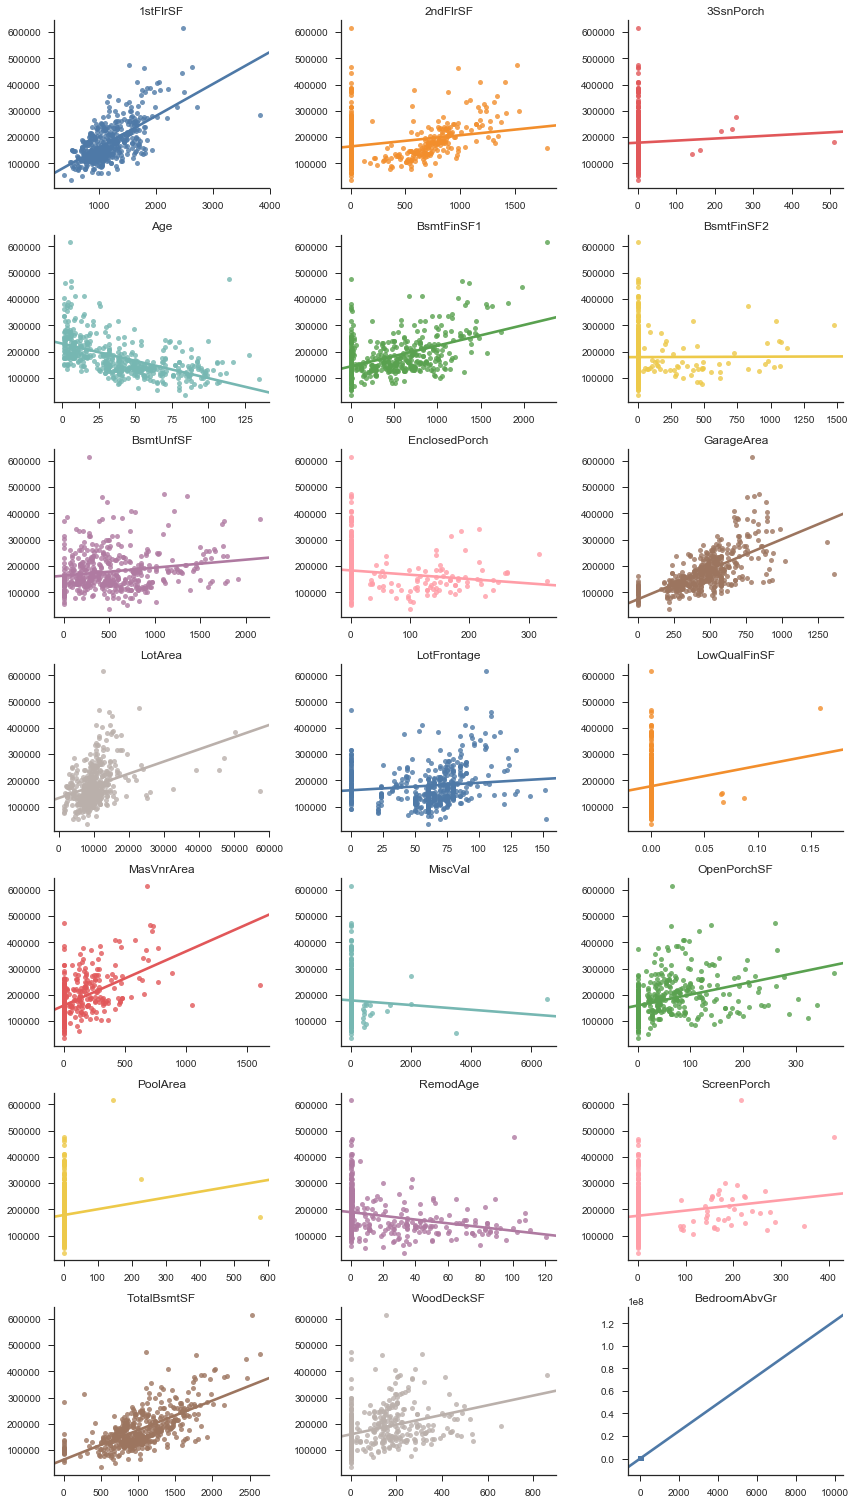

In [7]:
from statlearning import plot_regressions

with sns.color_palette(crayon):
    plot_regressions(X_train.iloc[:,:21], y_train)
    plt.show()

## Response Transformation

The above plots show that (i) the response variable is right skewed (ii) there are nonlinear relationships between the response and certain predictors (iii) the noise has non-constant variance as a function of the predictors (see for example the funnel shape in the first scatter plot). 

It is very common to observe these three patterns together in economic data, for reasons such as diminishing returns (additional space becomes less valuable if you have more space to begin with) and inflation (prices, salaries, etc, increase in percentage terms, not in a linear fashion).

In this situation, transforming the response will typically improve performance, as it is a parsimonious way to account for nonlinearities, reduce skewness, and make the noise variance near constant. The log transformation is the most common transformation of this type. 

In [8]:
y_train = np.log(train[response])
y_test = np.log(test[response])

Compare the univariate plots below with the original. 

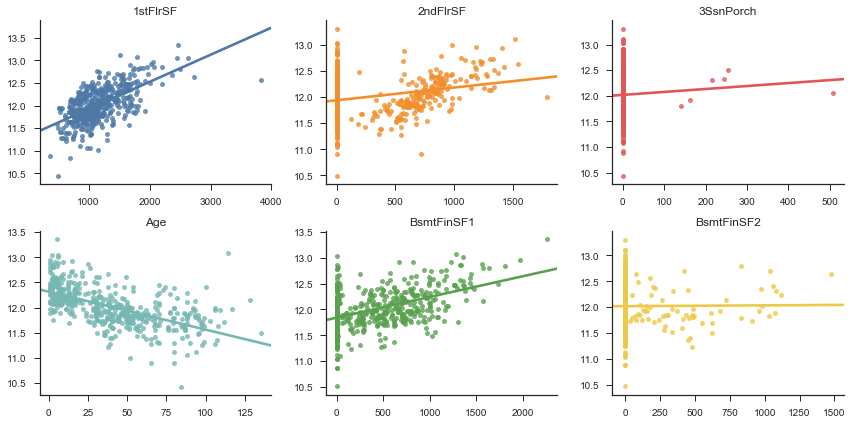

In [9]:
from statlearning import plot_regressions

with sns.color_palette(crayon):
    plot_regressions(X_train.iloc[:,:6], y_train)
    plt.show()

## Scaling the Predictors

It is essential to scale the predictors before fitting regularised linear methods. Like several other machine learning algorithms, regularised linear methods do not perform well when predictors have very different scales (because the penalty term in the objective function for training treats all coefficients as comparable).  

The most common type of scaling is standardisation, where we transform each predictor by subtracting its sample average and diving the result by its standard deviation. The Scikit-Learn [<TT>StandardScaler</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) method makes it easy to process the data in this way.

We have two ways of implementing a workflow that includes scaling. The first is to use the standard scaler to preprocess the design matrix, and then work with the transformed as usual. 

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

We use a ridge regression to illustrate the process of fitting the model and computing predictions, without worrying about the details of the algorithm for now. 

In [11]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_test_scaled)
print(y_pred[0]) # we will get the result below

11.2982722241


The other option is to use a Scikit-Learn [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline), which allows the user to combine transformations with a final estimator. 

In [12]:
from sklearn.pipeline import Pipeline

ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', Ridge()),
])

ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print(y_pred[0]) 

11.2982722241


## Regularised Linear Models

We first fit a linear regression for reference. 

In [13]:
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Lasso

We use the [<TT>LassoCV</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) class to fit and tune the lasso model. The reason for this class, as opposed to running a grid search on the [<TT>Lasso</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) class, is that there is an efficient algorithm for computing the path of solutions as we vary the lasso penalty. The same is true of other models. 

Below, we present code according to the two ways of handling predictor scaling. 

#### Method 1 

In [14]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

#### Method 2

In [15]:
lasso = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(cv=5)),
))

lasso.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False))])

We can assess the strength of regularisation by comparing the norm of the lasso coefficients with the OLS case. 

In [16]:
reg = lasso._final_estimator
round(np.linalg.norm(reg.coef_, ord=1)/np.linalg.norm(np.ravel(ols.coef_), ord=1),3)

0.079000000000000001

The lasso sets 88 of the coefficients to zero. 

In [17]:
np.sum(reg.coef_==0.0)

88

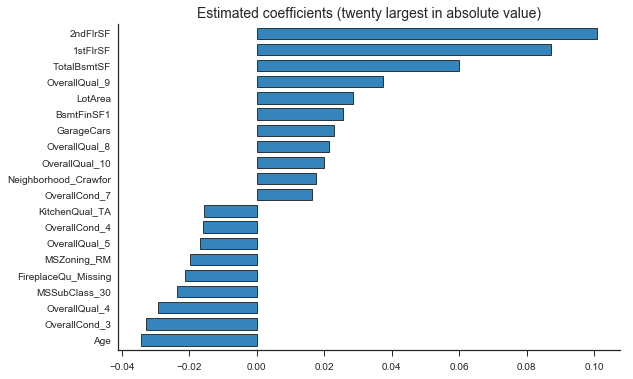

In [18]:
from statlearning import plot_coefficients

plot_coefficients(reg, predictors)
plt.show()

### Ridge Regression

In [19]:
from sklearn.linear_model import RidgeCV

alphas = list(np.logspace(-15, 15, 151, base=2))

ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train_scaled, y_train)

RidgeCV(alphas=[3.0517578125e-05, 3.5055491790680982e-05, 4.0268185753567341e-05, 4.6255998733837822e-05, 5.3134189654304478e-05, 6.103515625e-05, 7.0110983581361965e-05, 8.0536371507134683e-05, 9.2511997467675645e-05, 0.00010626837930860896, 0.0001220703125, 0.00014022196716272393, 0.00016107274301426937, ...05, 16384.0, 18820.273848271459, 21618.817610103131, 24833.500225706386, 28526.20085808741, 32768.0],
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [20]:
ridge = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=5)),
))

ridge.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', RidgeCV(alphas=[3.0517578125e-05, 3.5055491790680982e-05, 4.0268185753567341e-05, 4.6255998733837822e-05, 5.3134189654304478e-05, 6.103515625e-05, 7.0110983581361965e-05, 8.0536371507134683e-05, 9.251199746767...cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False))])

In [21]:
round(np.linalg.norm(ridge._final_estimator.coef_, ord=2)/np.linalg.norm(np.ravel(ols.coef_), ord=2),3)

0.034000000000000002

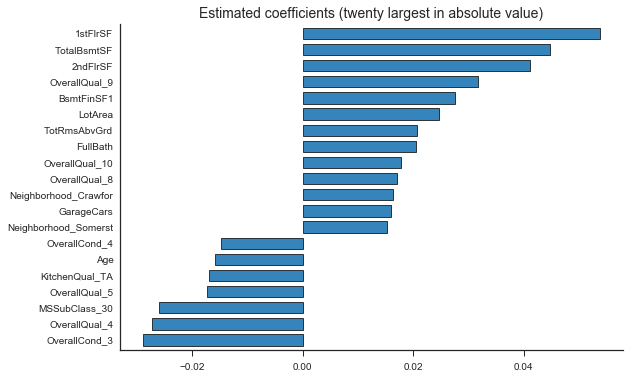

In [22]:
plot_coefficients(ridge._final_estimator, predictors)
plt.show()

### Elastic Net

In [23]:
from sklearn.linear_model import ElasticNetCV

enet = ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)
enet.fit(X_train_scaled, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99],
       max_iter=1000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [24]:
enet.l1_ratio_

0.98999999999999999

In [25]:
enet = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5, n_alphas=200)),
))

enet.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99],
       max_iter=1000, n_alphas=200, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0))])

## Model Evaluation

We compute the test results for the original price scale.

As a technical detail, we should make a bias correction when predicting the original response based on a model for a transformed response. However, the adjustment is very small for the current example (see below), so that we ignore it for simplicity. 

In [26]:
columns=['Test RMSE', 'Test R2', 'Test MAE']
rows=['OLS', 'Lasso', 'Ridge', 'Elastic Net']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols, lasso, ridge, enet]

for i, method in enumerate(methods):
    
    y_pred=method.predict(X_test)   
    results.iloc[i,0] = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))
    results.iloc[i,1] = r2_score(np.exp(y_test), np.exp(y_pred))
    results.iloc[i,2] = mean_absolute_error(np.exp(y_test), np.exp(y_pred))

results.round(3)

,Test RMSE,Test R2,Test MAE
OLS,31516.366,0.792,16134.551
Lasso,21064.675,0.907,13028.499
Ridge,21780.871,0.901,14008.729
Elastic Net,21057.507,0.907,13025.408


In [27]:
y_fit = lasso.predict(X_train) 
np.mean(np.exp(y_train-y_fit))   # leave-one-out residuals are better if convenient to compute 

1.0026020179685708

The code for computing the test predictions using this method is the following.  

In [28]:
y_pred = lasso.predict(X_test)
y_pred = y_pred*np.mean(np.exp(y_train-y_fit)) # the correction is based on the training data!